## Quantization

Quantization is a technique used to reduce the computational requirements and memory footprint of deep learning models. It works by reducing the precision of the numbers used to represent model parameters (weights) and activations, which can lead to significant improvements in GPU memory usage and inference speed.

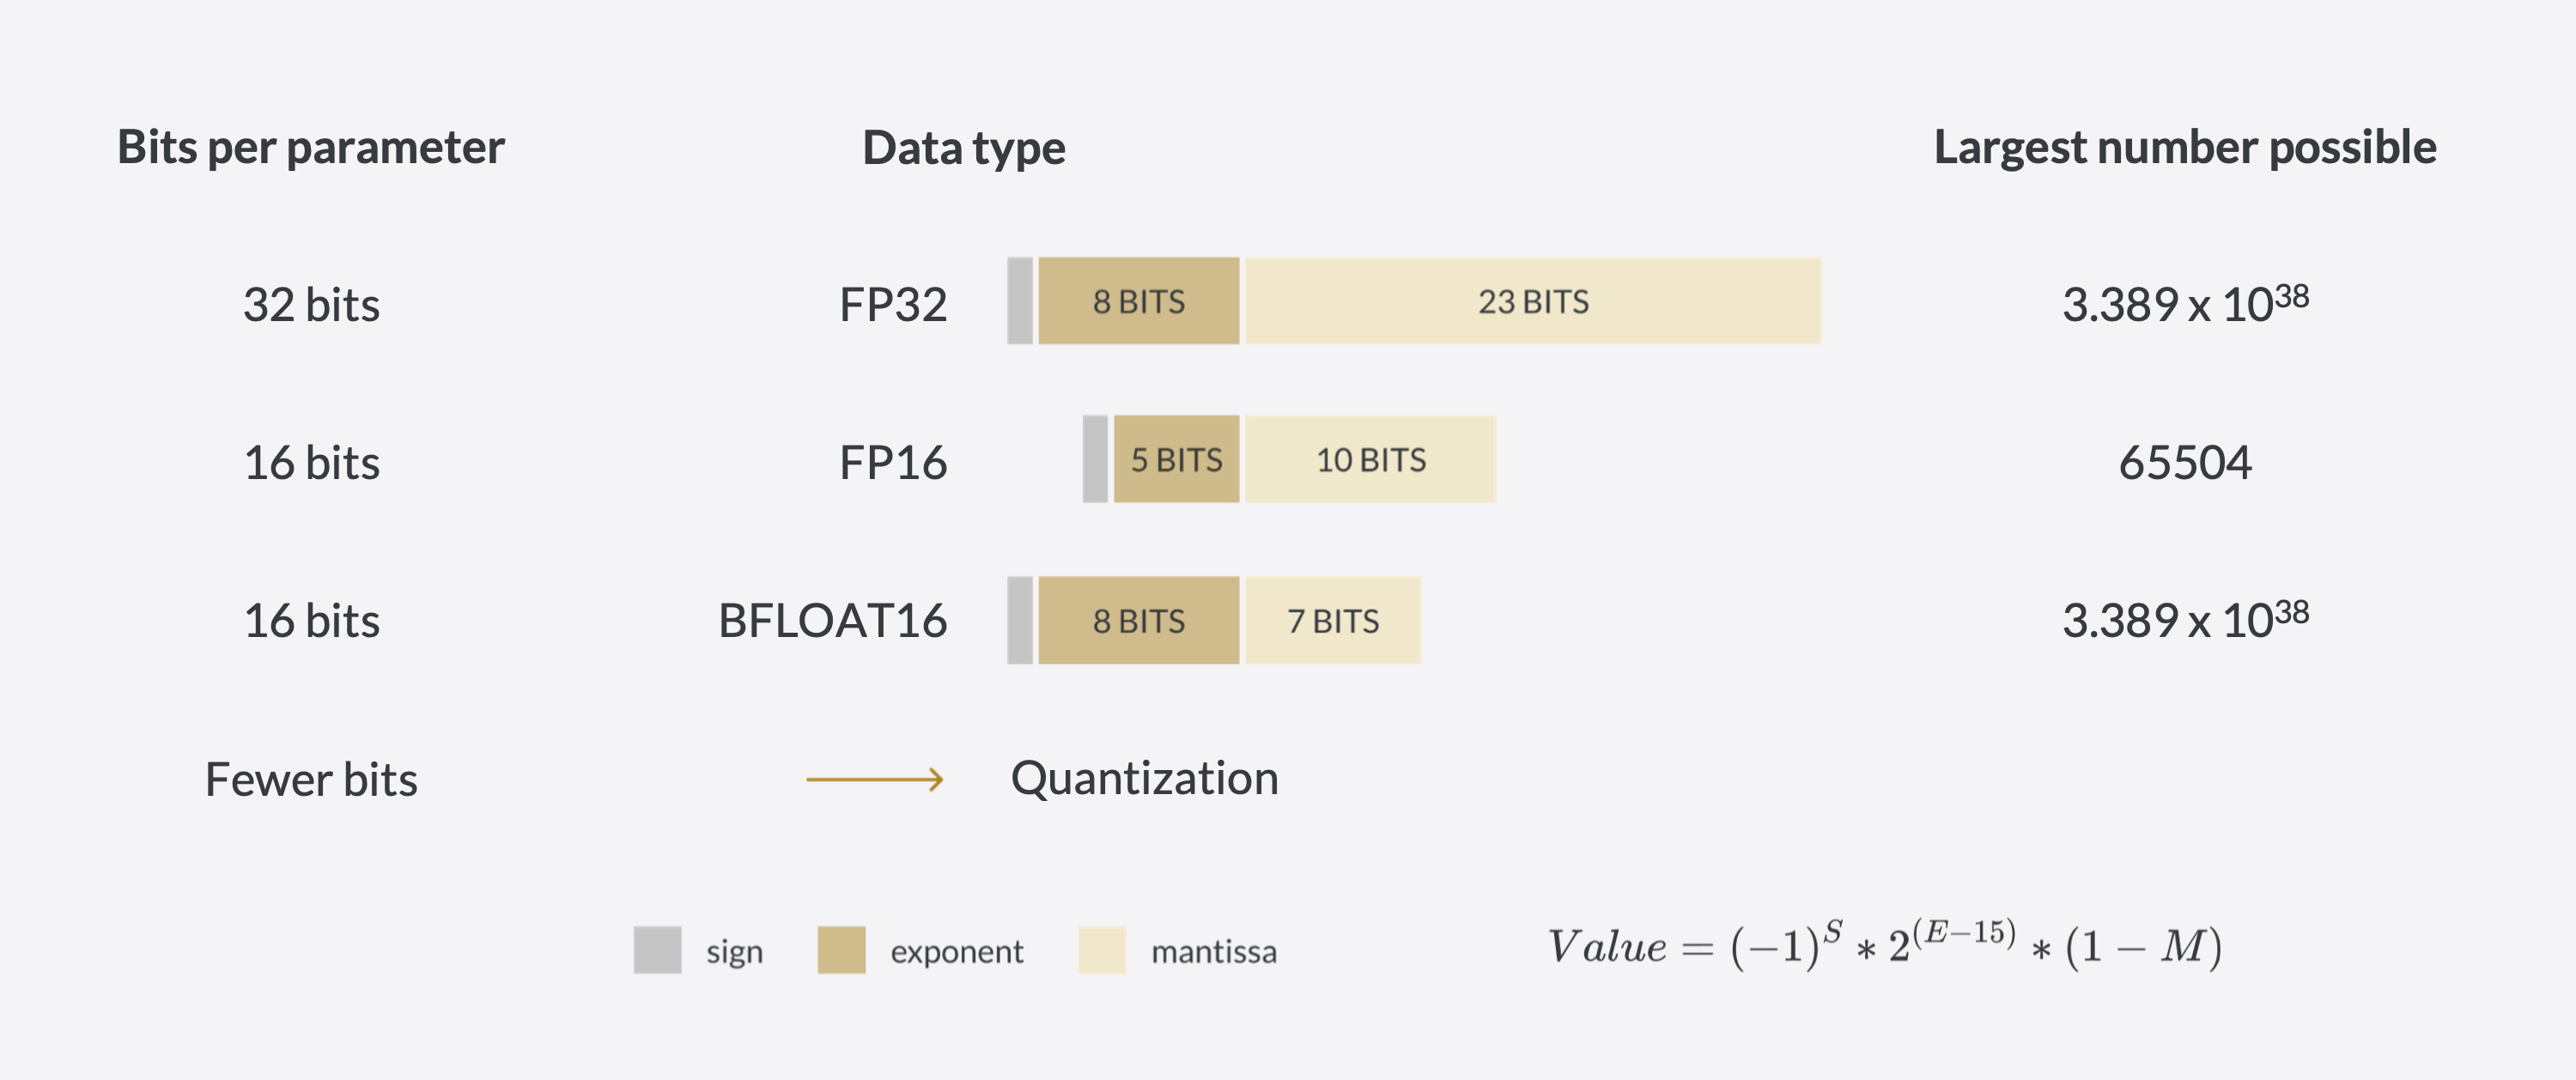

When using quantization, weights are converted to lower precision (e.g., from 32-bit floating-point to 4-bit integers) when loading the model. During inference, activations may remain in higher precision.



### Benefits of Quantization:

- **Reduced Model Size**: Quantization can significantly reduce the model's memory footprint, making it easier to deploy on edge devices.
- **Improved Inference Speed**: Lower precision arithmetic operations are generally faster, leading to reduced latency.

### Quantization Methods

There are many different quantization methods. An overview of the different quantization methods supported by the Huggingface Transformers library can be found in the [Huggingface Transformers documentation](https://huggingface.co/docs/transformers/main/quantization/overview).

<!-- https://base64.guru/converter/encode/image -->
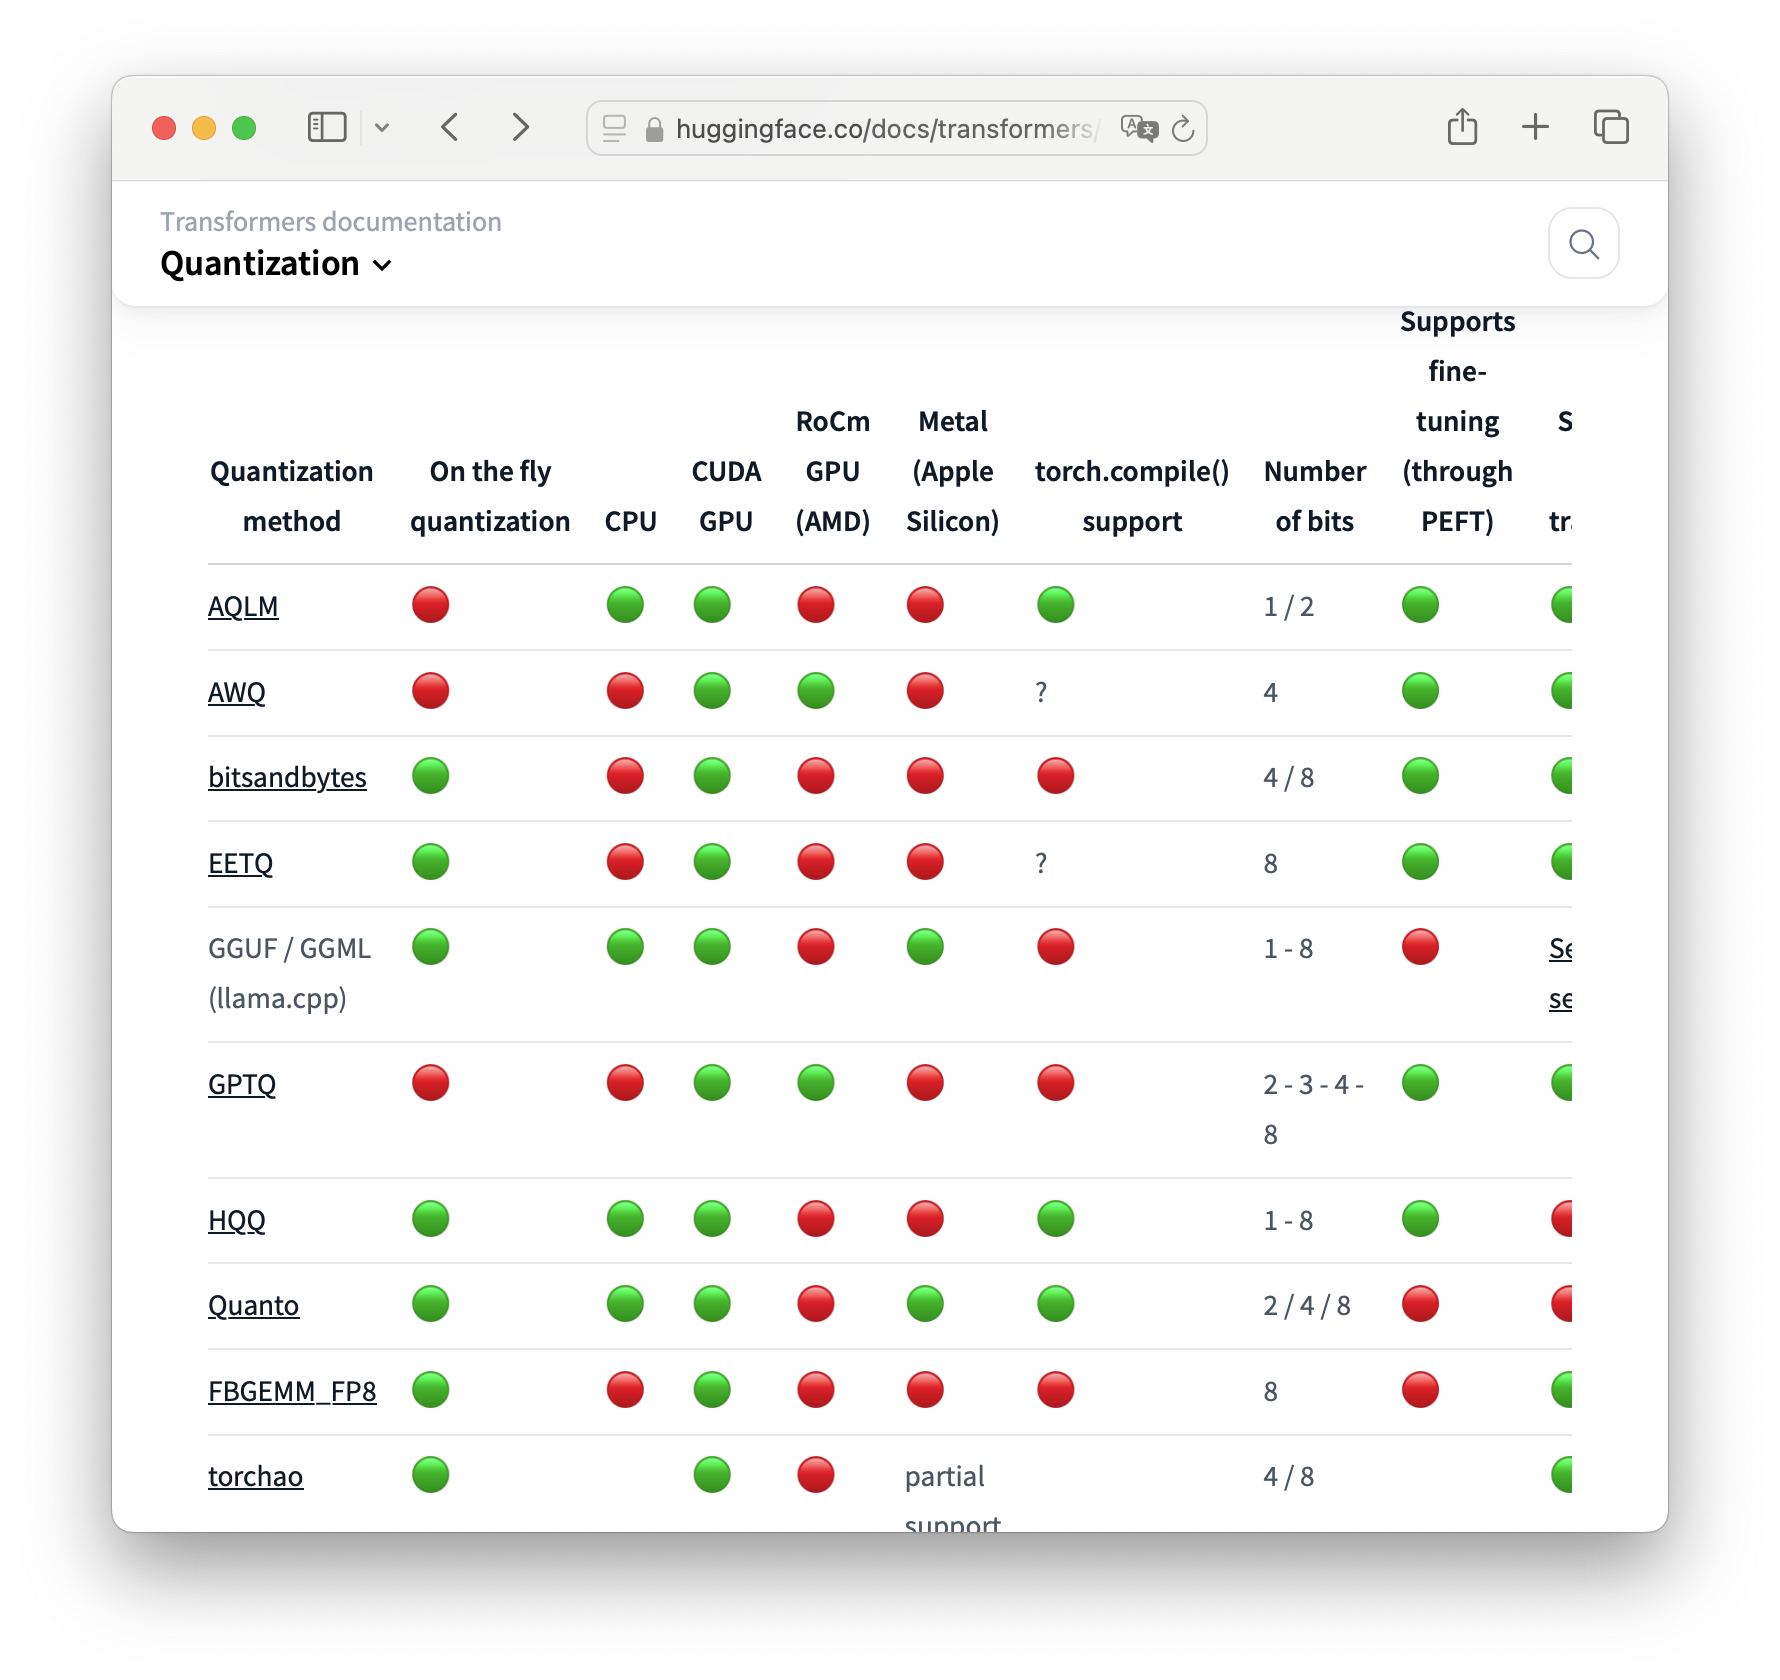

### Hands-On Example: Quantizing a Pre-trained Model

In this example, we will quantize a pre-trained chat model to reduce its GPU memory usage and we will measure the inference speed. We will use the bitsandbytes library.

In [1]:
# Import necessary libraries
import torch
from transformers import AutoModelForCausalLM, AutoModelForSequenceClassification, AutoTokenizer, pipeline, BitsAndBytesConfig
from datasets import Dataset, load_dataset

In [2]:
# Utility function to get model size:
def get_model_size(model):
    model_size = 0
    for param in model.parameters():
        model_size += param.nelement() * param.element_size()
    for buffer in model.buffers():
        model_size += buffer.nelement() * buffer.element_size()
    return model_size

**Explanation:** This function determines the size of a model, which is important to know since we are working with limited memory. It does not only take into account the number of parameters (weights & biases) and their datatypes, but also the buffers, which a model uses to e.g. run averages in batch normalization layers.

#### Choose a model and load tokenizer

In [3]:
# chat_model_name = "meta-llama/Llama-3.2-1B-Instruct"
chat_model_name = "/leonardo_scratch/fast/EUHPC_D20_063/huggingface/models/meta-llama--Llama-3.2-1B-Instruct"
chat_tokenizer = AutoTokenizer.from_pretrained(chat_model_name)
# For some models (such as LLama-3.2-1B-Instruct), we need to set a padding token and the padding side:
chat_tokenizer.pad_token_id = chat_tokenizer.eos_token_id
chat_tokenizer.padding_side='left'

#### Load model in FP32

In [4]:
chat_model_32bit = AutoModelForCausalLM.from_pretrained(
    chat_model_name,
    device_map="cuda", 
    torch_dtype=torch.float32,
    trust_remote_code=True)
chat_pipe_32bit = pipeline("text-generation", model=chat_model_32bit, tokenizer=chat_tokenizer)
print(f"The FP32 model uses {get_model_size(chat_model_32bit)/1024**3:.2f} GB of GPU memory")

Device set to use cuda


The FP32 model uses 4.60 GB of GPU memory


#### Create a pipeline for the model
A pipeline is a simple way to perform inference with a model. For text-generation models, we can use the following format for the question to the model:

In [5]:
messages = [
    {"role": "system", "content": "You are a helpful AI assistant."},
    {"role": "user", "content": "Can you solve the equation 2x + 3 = 7?"},
]

In [6]:
%time output = chat_pipe_32bit(messages, max_new_tokens=500, return_full_text=False)
print(output[0]["generated_text"])

CPU times: user 2.14 s, sys: 424 ms, total: 2.57 s
Wall time: 2.63 s
To solve for x, we need to isolate x on one side of the equation. We can do this by subtracting 3 from both sides of the equation:

2x + 3 - 3 = 7 - 3

This simplifies to:

2x = 4

Next, we can divide both sides of the equation by 2 to solve for x:

2x / 2 = 4 / 2

x = 2

So, the value of x is 2.


#### Load model in BF16

In [7]:
chat_model_16bit = AutoModelForCausalLM.from_pretrained(
    chat_model_name,
    device_map="cuda",
    torch_dtype=torch.bfloat16,
    trust_remote_code=True)
chat_pipe_16bit = pipeline("text-generation", model=chat_model_16bit, tokenizer=chat_tokenizer)
print(f"The BF16 model uses {get_model_size(chat_model_16bit)/1024**3:.2f} GB of GPU memory")

Device set to use cuda


The BF16 model uses 2.30 GB of GPU memory


In [8]:
%time output = chat_pipe_16bit(messages, max_new_tokens=500, return_full_text=False)
print(output[0]["generated_text"])

CPU times: user 1.55 s, sys: 132 ms, total: 1.68 s
Wall time: 1.78 s
To solve the equation 2x + 3 = 7, we need to isolate the variable x.

First, subtract 3 from both sides of the equation:

2x + 3 - 3 = 7 - 3
2x = 4

Next, divide both sides of the equation by 2:

2x / 2 = 4 / 2
x = 2

So, the value of x is 2.


#### Load model in 4 bit quantization

In [9]:
chat_model_4bit = AutoModelForCausalLM.from_pretrained(
    chat_model_name,
    device_map="cuda", 
    torch_dtype=torch.bfloat16,
    quantization_config=BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    ),
    trust_remote_code=True)
chat_pipe_4bit = pipeline("text-generation", model=chat_model_4bit, tokenizer=chat_tokenizer)
print(f"The 4bit model uses {get_model_size(chat_model_4bit)/1024**3:.2f} GB of GPU memory")

Device set to use cuda


The 4bit model uses 0.94 GB of GPU memory


In [10]:
%time output = chat_pipe_4bit(messages, max_new_tokens=500, return_full_text=False)
print(output[0]["generated_text"])

CPU times: user 1.93 s, sys: 2.27 ms, total: 1.93 s
Wall time: 1.94 s
To solve for x, I'll first subtract 3 from both sides of the equation:

2x + 3 - 3 = 7 - 3
2x = 4

Next, I'll divide both sides by 2:

2x / 2 = 4 / 2
x = 2

So, the solution to the equation 2x + 3 = 7 is x = 2.


#### Questions to Consider:

1. How does the size reduction differ between the three data types (FP32, BFLOAT16, 4 bit quantization)?
2. How does the inference speed depend on the data type used for loading the model?

The first question was already answered, but for the second question we only checked inference speed for a single prompt, where the overhead might take much longer than the actual calculation on the GPU. To get a better idea of the difference in speed, we will now load a dataset and query the model a lot of times.

In [11]:
# Load the guanaco dataset
guanaco_train = load_dataset('/leonardo_scratch/fast/EUHPC_D20_063/huggingface/datasets/timdettmers--openassistant-guanaco', split='train[:64]')
# guanaco_test = load_dataset('/leonardo_scratch/fast/EUHPC_D20_063/huggingface/datasets/timdettmers--openassistant-guanaco', split='test')
# guanaco_train = load_dataset('timdettmers/openassistant-guanaco', split='train')
# guanaco_test = load_dataset('timdettmers/openassistant-guanaco', split='test')

Repo card metadata block was not found. Setting CardData to empty.


In [12]:
guanaco_train

Dataset({
    features: ['text'],
    num_rows: 64
})

In [13]:
guanaco_train[0]

{'text': '### Human: Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.### Assistant: "Monopsony" refers to a market structure where there is only one buyer for a particular good or service. In economics, this term is particularly relevant in the labor market, where a monopsony employer has significant power over the wages and working conditions of their employees. The presence of a monopsony can result in lower wages and reduced employment opportunities for workers, as the employer has little incentive to increase wages or provide better working conditions.\n\nRecent research has identified potential monopsonies in industries such as retail and fast food, where a few large companies control a significant portion of the market (Bivens & Mishel, 2013). In these industries, workers often face low wages, limited benefits, and reduced bargaining po

In [14]:
guanaco_train[0]['text'].split('###')

['',
 ' Human: Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.',
 ' Assistant: "Monopsony" refers to a market structure where there is only one buyer for a particular good or service. In economics, this term is particularly relevant in the labor market, where a monopsony employer has significant power over the wages and working conditions of their employees. The presence of a monopsony can result in lower wages and reduced employment opportunities for workers, as the employer has little incentive to increase wages or provide better working conditions.\n\nRecent research has identified potential monopsonies in industries such as retail and fast food, where a few large companies control a significant portion of the market (Bivens & Mishel, 2013). In these industries, workers often face low wages, limited benefits, and reduced bargaining power,

In [15]:
guanaco_train[0]['text'].split('###')[1].removeprefix(' Human: ')

'Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.'

In [16]:
guanaco_train[0]['text'].split('###')[2].removeprefix(' Assistant: ')

'"Monopsony" refers to a market structure where there is only one buyer for a particular good or service. In economics, this term is particularly relevant in the labor market, where a monopsony employer has significant power over the wages and working conditions of their employees. The presence of a monopsony can result in lower wages and reduced employment opportunities for workers, as the employer has little incentive to increase wages or provide better working conditions.\n\nRecent research has identified potential monopsonies in industries such as retail and fast food, where a few large companies control a significant portion of the market (Bivens & Mishel, 2013). In these industries, workers often face low wages, limited benefits, and reduced bargaining power, leading to a situation where they are dependent on the employer for their livelihood. This dependence can result in further suppression of wages and a decline in working conditions.\n\nOverall, the concept of monopsony is es

In [17]:
guanaco_train = guanaco_train.map(lambda entry: {
    'question1': entry['text'].split('###')[1].removeprefix(' Human: '),
    'answer1': entry['text'].split('###')[2].removeprefix(' Assistant: ')
})

Map:   0%|          | 0/64 [00:00<?, ? examples/s]

In [18]:
guanaco_train[2]

{'text': '### Human: Can you explain contrastive learning in machine learning in simple terms for someone new to the field of ML?### Assistant: Sure! Let\'s say you want to build a model which can distinguish between images of cats and dogs. You gather your dataset, consisting of many cat and dog pictures. Then you put them through a neural net of your choice, which produces some representation for each image, a sequence of numbers like [0.123, 0.045, 0.334, ...]. The problem is, if your model is unfamiliar with cat and dog images, these representations will be quite random. At one time a cat and a dog picture could have very similar representations (their numbers would be close to each other), while at others two cat images may be represented far apart. In simple terms, the model wouldn\'t be able to tell cats and dogs apart. This is where contrastive learning comes in.\n\nThe point of contrastive learning is to take pairs of samples (in this case images of cats and dogs), then train 

In [19]:
%time answers_32bit = chat_pipe_32bit(guanaco_train['question1'], batch_size=64)

CPU times: user 23.2 s, sys: 45.3 ms, total: 23.2 s
Wall time: 23.4 s


In [20]:
%time answers_16bit = chat_pipe_16bit(guanaco_train['question1'], batch_size=64)

CPU times: user 11.4 s, sys: 56 ms, total: 11.5 s
Wall time: 11.5 s


In [21]:
%time answers_4bit = chat_pipe_4bit(guanaco_train['question1'], batch_size=64)

CPU times: user 12.7 s, sys: 4.2 ms, total: 12.7 s
Wall time: 12.8 s


### Conclusion

In this notebook, we introduced quantization as a technique to reduce model size and improve inference speed. You learned how to quantize a model and evaluate its performance.

<!--- ### Next Steps:
In the next notebook, we will explore Parameter-Efficient Fine-Tuning (PEFT) techniques to further optimize model training. -->

In [22]:
# Shut down the kernel to release memory
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(restart=False)

{'status': 'ok', 'restart': False}